# CVODE

CVODE python library are available here: https://pypi.org/project/pycvodes/

## Van der Pol Oscillator

### Governing Equations

\begin{eqnarray}
\frac{dx}{dt}&=&y\\
\frac{dy}{dt}&=&-x+\mu y(1-x^2)
\end{eqnarray}

### Code

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge pycvodes pytest

Solving environment: done

# All requested packages already installed.



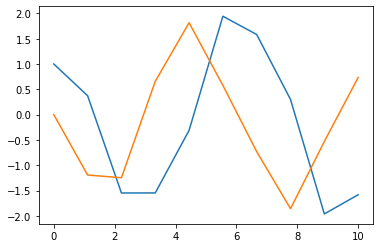

In [1]:
import numpy as np
from pycvodes import integrate_predefined  # also: integrate_adaptive
mu = 1.0
def f(t, y, dydt):
    dydt[0] = y[1]
    dydt[1] = -y[0] + mu*y[1]*(1 - y[0]**2)

def j(t, y, Jmat, dfdt=None, fy=None):
    Jmat[0, 0] = 0
    Jmat[0, 1] = 1
    Jmat[1, 0] = -1 - mu*2*y[1]*y[0]
    Jmat[1, 1] = mu*(1 - y[0]**2)
    if dfdt is not None:
        dfdt[:] = 0
y0 = [1, 0]; dt0=1e-2; t0=0.0; atol=1e-8; rtol=1e-8
tout = np.linspace(0, 10.0, 10)
yout, info = integrate_predefined(f, j, y0, tout, atol, rtol, dt0,
                                  method='bdf')
import matplotlib.pyplot as plt
series = plt.plot(tout, yout)
plt.show()  # doctest: +SKIP

## FENE-P Equation

### Governing equations

Steady velocity gradient $S$

\begin{eqnarray}
\frac{d C_{xx}}{dt}&=&2C_{xy} S -\frac{1}{Wi}\left(\frac{C_{xx}}{1-(C_{xx}+C_{yy})/b}-1\right)\\
\frac{d C_{yy}}{dt}&=& -\frac{1}{Wi}\left(\frac{C_{yy}}{1-(C_{xx}+C_{yy})/b}-1\right)\\
\frac{d C_{xy}}{dt}&=&C_{xx} S -\frac{1}{Wi}\left(\frac{C_{xy}}{1-(C_{xx}+C_{yy})/b}\right)
\end{eqnarray}

$$
C_{xx}+C_{yy} = b +\epsilon 
$$
$$
\frac{d C_{xx}}{dt}=2C_{xy} S -\frac{1}{Wi}\left(\frac{C_{xx}}{1-(1+\epsilon/b)}-1\right)
$$
$$
\frac{d C_{xx}}{dt}=2C_{xy} S +\frac{1}{Wi}\left(\frac{bC_{xx}}{\epsilon}-1\right)
$$

### CVODE-type equations

\begin{eqnarray}
\frac{dy_0}{dt} &=& 2Sy_2 - \frac{1}{Wi}\left(\frac{y_0}{1-(y_0+y_1)/b}-1\right)+\frac{\sigma}{(y_0-r_g)^n}\\
\frac{dy_1}{dt} &=& - \frac{1}{Wi}\left(\frac{y_1}{1-(y_0+y_1)/b}-1\right)+\frac{\sigma}{(y_1-r_g)^n}\\
\frac{dy_2}{dt} &=& Sy_1 - \frac{1}{Wi}\left(\frac{y_2}{1-(y_0+y_1)/b}\right)
\end{eqnarray}

### Jacobian
\begin{eqnarray}
J_{0,0}&=&-\frac{1}{Wi}\left(\frac{1}{1-(y_0+y_1)/b}+\frac{y_0/b}{(1-(y_0+y_1)/b)^2}\right)-\frac{n\sigma}{(y_0-r_g)^{n+1}}\\
J_{0,1}&=&-\frac{1}{Wi}\left(\frac{y_0/b}{(1-(y_0+y_1)/b)^2}\right)\\
J_{0,2}&=&2S \\
J_{1,0}&=&-\frac{1}{Wi}\left(\frac{y_1/b}{(1-(y_0+y_1)/b)^2}\right)\\
J_{1,1}&=&-\frac{1}{Wi}\left(\frac{1}{1-(y_0+y_1)/b}+\frac{y_1/b}{(1-(y_0+y_1)/b)^2}\right)-\frac{n\sigma}{(y_1-r_g)^{n+1}}\\
J_{1,2}&=&0\\
J_{2,0}&=&-\frac{1}{Wi}\left(\frac{y_2/b}{(1-(y_0+y_1)/b)^2}\right)\\
J_{2,1}&=&S-\frac{1}{Wi}\left(\frac{y_2/b}{(1-(y_0+y_1)/b)^2}\right)\\
J_{2,2}&=&-\frac{1}{Wi}\left(\frac{1}{1-(y_0+y_1)/b}\right)
\end{eqnarray}

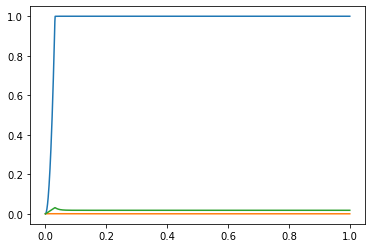

Cxx= 9.99275e+02, Cyy= 6.70268e-01, Cxy= 1.83000e+01


In [36]:
import numpy as np
from pycvodes import integrate_predefined  # also: integrate_adaptive
Wi = 1000.
S = 1e3
b = 1000.**2
sigma = 1.0
ng = 8.
rg = 0

def f(t, y, dydt):
    global S,n,rg,ng,sigma,Wi,b
    dydt[0] = 2*S*y[2] - (1/Wi)*(y[0]/(1-(y[0]+y[1])/b)-1) + sigma/(y[0] - rg)**ng
    dydt[1] =          - (1/Wi)*(y[1]/(1-(y[0]+y[1])/b)-1) + sigma/(y[1] - rg)**ng
    dydt[2] = S*y[1] - (1/Wi)*(y[2]/(1-(y[0]+y[1])/b))
    
def j(t, y, Jmat, dfdt=None, fy=None):
    global S,n,rg,ng,sigma,Wi,b
    Jmat[0, 0] = -(1/Wi)*(1/(1-(y[0]+y[1])/b) + (1/b)*y[0]/(1-(y[0]+y[1])/b)**2) \
                 - ng*sigma/(y[0] - rg)**(ng+1)
    Jmat[0, 1] = -(1/Wi)*( (1/b)*y[0]/(1-(y[0]+y[1])/b)**2)
    Jmat[0, 2] = 2*S
    Jmat[1, 0] = -(1/Wi)*((1/b)*y[1]/(1-(y[0]+y[1])/b)**2)
    Jmat[1, 1] = -(1/Wi)*(1/(1-(y[0]+y[1])/b) + (1/b)*y[1]/(1-(y[0]+y[1])/b)**2) \
                 - ng*sigma/(y[1] - rg)**(ng+1)
    Jmat[1, 2] = 0
    Jmat[2, 0] = - (1/Wi)*((y[2]/b)/(1-(y[0]+y[1])/b)**2)
    Jmat[2, 1] = S- (1/Wi)*((y[2]/b)/(1-(y[0]+y[1])/b)**2)
    Jmat[2, 0] = - (1/Wi)*(1/(1-(y[0]+y[1])/b))
                    
    if dfdt is not None:
        dfdt[:] = 0
Ns = 100
b_array = np.array([10,100,1000])
Nb = len(b_array)
Wi_array = np.array([10,100,500])
Nwi = len(Wi_array)
S_array = np.logspace(-2,3,Ns)
t_array = (S_array[-1]/S_array)**(3./5.)
trC = np.zeros((Ns,Nb,Nwi))
trCb = np.zeros((Ns,Nb,Nwi))
# y0 = [1, np.sqrt(10), 0]; dt0=1e-1; t0=0.0; atol=1e-8; rtol=1e-8
# tout = np.linspace(0, 1, 100)
# yout, info = integrate_predefined(f, j, y0, tout, atol, rtol, dt0,
#                                       method='bdf')
for iS in range(Ns):
    S = S_array[iS]
    for ib in range(Nb):
        b = b_array[ib]
        for iWi in range(Nwi):
            Wi = Wi_array[iWi]
#             print(S,b,Wi)
            y0 = [1, 1, 0]; dt0=1e-1; t0=0.0; atol=1e-8; rtol=1e-8
            tout = np.linspace(0, t_array[iS], 1000)
            yout, info = integrate_predefined(f, j, y0, tout, atol, rtol, dt0,method='bdf')
            trC[iS,ib,iWi] = yout[-1,0] + yout[-1,1]
            trCb[iS,ib,iWi] = trC[iS,ib,iWi]/b
import matplotlib.pyplot as plt
series = plt.plot(tout, yout/b)
plt.show()  # doctest: +SKIP
print("Cxx= %.5e, Cyy= %.5e, Cxy= %.5e" %(yout[-1,0],yout[-1,1],yout[-1,2]))

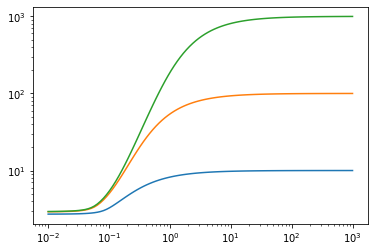

In [46]:
plt.loglog(S_array,trC[:,:,0])

In [4]:
toutref = np.copy(tout)
youtref = np.copy(yout)

### An example that doesn't work

Below is a simple Euler integration (first order). The simulation fails to converge with $\Delta t = 10^{-2}$ but does for $\Delta t= 10^{-3}$

20000 20000


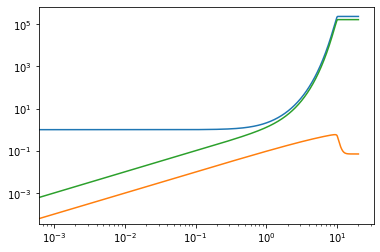

Cxx= 0.00000e+00, Cyy= 0.00000e+00, Cxy= 0.00000e+00


In [5]:
# %%timeit # if timing comment plotting and printing at the end
b = 500**2
Wi = 10
S = 1
dt = 1e-3
tmax = 20.
y0 = [1, 0, 0]
t = 0.
dydt0 = [0, 0, 0]
def f(t, y, dydt):
    dydt[0] = 2*S*y[2] - (1/Wi)*(y[0]/(1-(y[0]+y[1])/b)-1)
    dydt[1] =          - (1/Wi)*(y[1]/(1-(y[0]+y[1])/b)-1)
    dydt[2] = S*y[0] - (1/Wi)*(y[2]/(1-(y[0]+y[1])/b))
N = int(round(tmax / dt))
tout = np.zeros(N+2)
yout = np.zeros((N+2,3))
dydtout = np.zeros((N+2,3))
yout[0,:] = y0
dydtout[0,:] = dydt0
i = 0
while t < tmax:
    i += 1
    t += dt
    tout[i] = t
    y = yout[i-1]
    dydt = dydtout[i-1]
    f(t,y,dydt)
    dydtout[i,:] = dydt
    yout[i,:] = y + dt*dydt
print(i,N)    
import matplotlib.pyplot as plt
series = plt.loglog(tout[:-1], yout[:-1])
plt.show()
print("Cxx= %.5e, Cyy= %.5e, Cxy= %.5e" %(yout[-1,0]/b,yout[-1,1]/b,yout[-1,2]/b))

### Implementation of CVODE as a subiterative process

Consider a problem where the time step is governed by other dynamics (flow) which operates on a time scale greater than that of the polymers. The following code solves the problem,  using CVODE to move the solution from $t$ to $t+\Delta t$. Try $\Delta t = 1,0.1,0.01,0.001$

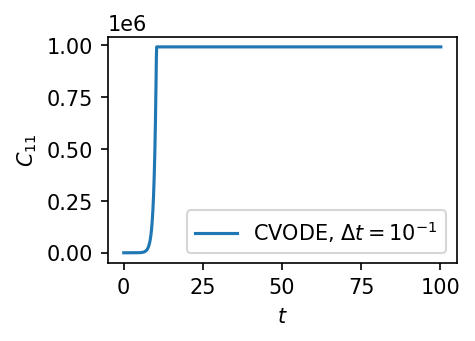

Cxx= 9.92929e+05, Cyy= 7.07107e-03, Cxy= 7.02107e+05


In [6]:
# %%timeit # if timing comment plotting and printing at the end
b = 1000**2
Wi = 100
S = 1
dt = 1e-1
tmax = 100.
y0 = [1, 0, 0]
t = 0.
dydt0 = [0, 0, 0]
def f(t, y, dydt):
    dydt[0] = 2*S*y[2] - (1/Wi)*(y[0]/(1-(y[0]+y[1])/b)-1)
    dydt[1] =          - (1/Wi)*(y[1]/(1-(y[0]+y[1])/b)-1)
    dydt[2] = S*y[0] - (1/Wi)*(y[2]/(1-(y[0]+y[1])/b))
def j(t, y, Jmat, dfdt=None, fy=None):
    Jmat[0, 0] = -(1/Wi)*(1/(1-(y[0]+y[1])/b) + (1/b)*y[0]/(1-(y[0]+y[1])/b)**2)
    Jmat[0, 1] = -(1/Wi)*( (1/b)*y[0]/(1-(y[0]+y[1])/b)**2)
    Jmat[0, 2] = 2*S
    Jmat[1, 0] = -(1/Wi)*((1/b)*y[1]/(1-(y[0]+y[1])/b)**2)
    Jmat[1, 1] = -(1/Wi)*(1/(1-(y[0]+y[1])/b) + (1/b)*y[1]/(1-(y[0]+y[1])/b)**2)
    Jmat[1, 2] = 0
    Jmat[2, 0] = S - (1/Wi)*((y[2]/b)/(1-(y[0]+y[1])/b)**2)
    Jmat[2, 1] = - (1/Wi)*((y[2]/b)/(1-(y[0]+y[1])/b)**2)
    Jmat[2, 0] = - (1/Wi)*(1/(1-(y[0]+y[1])/b))
                    
    if dfdt is not None:
        dfdt[:] = 0


N = int(round(tmax / dt))
tout = np.zeros(N+2)
yout = np.zeros((N+2,3))
dydtout = np.zeros((N+2,3))
yout[0,:] = y0
dydtout[0,:] = dydt0
i = 0
while t < tmax:
    i += 1
    t += dt
    tout[i] = t
    y = yout[i-1]
    dydt = dydtout[i-1]
    toutsub = np.linspace(t-dt, t, 10) # if I had not coded the incremental change in t above, it'd be t to t+dt
    dt0=1e-2; t0=0.0; atol=1e-8; rtol=1e-8
    youtsub, info = integrate_predefined(f, j, y, toutsub, atol, rtol, dt0,
                                  method='bdf')
#     youtsub, info = integrate_predefined(f, y0=y, toutsub, atol, rtol, dt0,
#                                   method='bdf')
    

    yout[i,:] = youtsub[-1,:]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2),dpi=150)
series = plt.plot(tout, yout[:,0], label=r"CVODE, $\Delta t=10^{-1}$")
# seriesref = plt.plot(toutref[::4],youtref[::4,0],'--', label=r"RK2, $\Delta t=10^{-3}$")
plt.xlabel(r"$t$")
plt.ylabel(r"$C_{11}$")
plt.legend(loc=4)
plt.savefig("cvode.png",bbox_inches="tight")
plt.show()   
print("Cxx= %.5e, Cyy= %.5e, Cxy= %.5e" %(yout[-1,0],yout[-1,1],yout[-1,2]))

In [7]:
?integrate_predefined

# Performance

Using timeit, the performances of the Euler method (the fastest) and sub-iterative CVODE are compared for different time steps. 

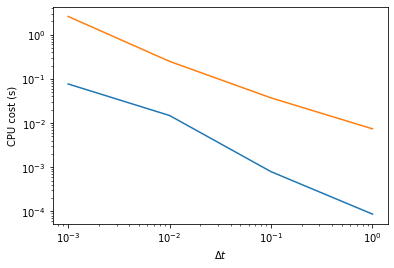

In [8]:
Deltat = np.array([1e-3, 1e-2, 1e-1, 1e0])
costEuler = np.array([76.7e-3, 14.8e-3, 792e-6, 86.7e-6 ])
costCVODE = np.array([2.59, 249e-3, 37.1e-3  ,7.39e-3])

plt.loglog(Deltat, costEuler)
plt.loglog(Deltat, costCVODE)
plt.xlabel(r"$\Delta t$")
plt.ylabel(r"CPU cost (s)")
plt.show()

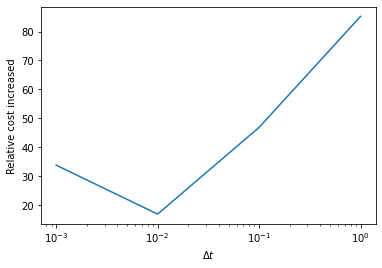

In [9]:
plt.semilogx(Deltat, costCVODE/costEuler)
plt.xlabel(r"$\Delta t$")
plt.ylabel(r"Relative cost increased")
plt.show()

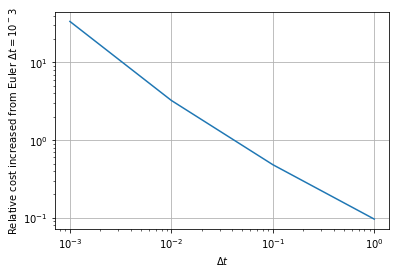

In [10]:
plt.loglog(Deltat, costCVODE/costEuler[0])
plt.grid(True)
plt.xlabel(r"$\Delta t$")
plt.ylabel(r"Relative cost increased from Euler $\Delta t=10^-3$")
plt.show()

Using CVODE increases the computational cost, however it allows for much larger time step while guaranteeing convergence. In fact the no-extra cost point from the converged solution at $\Delta t= 10^{-3}$ is for $\Delta t\approx 4\times10^{-2}$.

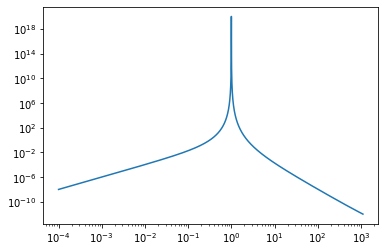

In [11]:
L = 100
b = L**2
eps = 10
C = np.logspace(-4,3,10000)
Fpeterlin = C/(1. - C/b)
Fcoil = np.abs((C)**2/(1-C)**6)
# plt.loglog(C,Fpeterlin)
# plt.loglog(C,Fcoil)
plt.loglog(Fpeterlin,Fcoil)
plt.show()

## FENE-P Equation

### Governing equations

Steady velocity gradient $S$

\begin{eqnarray}
\frac{d C_{xx}}{dt}&=&2(C_{xx}\partial_xu_x +C_{xy}\partial_yu_x) -\frac{1}{Wi}\left(\frac{C_{xx}}{1-(C_{xx}+C_{yy})/b}-1\right)+\frac{\sigma}{C_{xx}^n}\\
\frac{d C_{yy}}{dt}&=& 2(C_{xy}\partial_xu_y+C_{yy}\partial_yu_y)-\frac{1}{Wi}\left(\frac{C_{yy}}{1-(C_{xx}+C_{yy})/b}-1\right)+\frac{\sigma}{C_{yy}^n}\\
\frac{d C_{xy}}{dt}&=&C_{xx}\partial_xu_y +C_{yy}\partial_yu_x -\frac{1}{Wi}\left(\frac{C_{xy}}{1-(C_{xx}+C_{yy})/b}\right)
\end{eqnarray}


\begin{eqnarray}
\frac{d y_0}{dt}&=&2(y_0\partial_xu_x +y_2\partial_yu_x) -\frac{1}{Wi}\left(\frac{y_0}{1-(y_0+y_1)/b}-1\right)+\frac{\sigma}{y_0^n}\\
\frac{d y_1}{dt}&=& 2(y_2\partial_xu_y+y_1\partial_yu_y)-\frac{1}{Wi}\left(\frac{y_1}{1-(y_0+y_1)/b}-1\right)+\frac{\sigma}{y_1^n}\\
\frac{d y_2}{dt}&=&y_0\partial_xu_y +y_1\partial_yu_x -\frac{1}{Wi}\left(\frac{y_2}{1-(y_0+y_1)/b}\right)
\end{eqnarray}

In [48]:
def f(t, y, dydt):
    global nabla_u,sigma,Wi,b,n
    dydt[0] = 2*(y[0]*nabla_u[0,0]+y[2]*nabla_u[0,1]) - (1/Wi)*(y[0]/(1-(y[0]+y[1])/b)-1) + sigma/y[0]**n
    dydt[1] = 2*(y[2]*nabla_u[1,0]+y[1]*nabla_u[1,1]) - (1/Wi)*(y[1]/(1-(y[0]+y[1])/b)-1) + sigma/y[1]**n
    dydt[2] = y[0]*nabla_u[1,0] +y[1]*nabla_u[0,1] - (1/Wi)*(y[2]/(1-(y[0]+y[1])/b))

In [49]:

def j(t, y, Jmat, dfdt=None, fy=None):
    global nabla_u,sigma,Wi,b,n
    Jmat[0, 0] = 2*nabla_u[0,0] - (1/Wi)*(1/(1-(y[0]+y[1])/b) + (1/b)*y[0]/(1-(y[0]+y[1])/b)**2) - n*sigma/y[0]**(n+1)
    Jmat[0, 1] = -(1/Wi)*( (1/b)*y[0]/(1-(y[0]+y[1])/b)**2)
    Jmat[0, 2] = 2*nabla_u[0,1]
    Jmat[1, 0] = -(1/Wi)*((1/b)*y[1]/(1-(y[0]+y[1])/b)**2)
    Jmat[1, 1] = 2*nabla_u[1,1] - (1/Wi)*(1/(1-(y[0]+y[1])/b) + (1/b)*y[1]/(1-(y[0]+y[1])/b)**2) - n*sigma/y[1]**(n+1)
    Jmat[1, 2] = 2*nabla_u[1,0]
    Jmat[2, 0] = nabla_u[1,0] - (1/Wi)*((y[2]/b)/(1-(y[0]+y[1])/b)**2)
    Jmat[2, 1] = nabla_u[0,1] - (1/Wi)*((y[2]/b)/(1-(y[0]+y[1])/b)**2)
    Jmat[2, 0] = - (1/Wi)*(1/(1-(y[0]+y[1])/b))
                    
    if dfdt is not None:
        dfdt[:] = 0

In [50]:
Nx = 256
C = np.ones((Nx,2,2))
C[:,0,1] = C[:,1,0]
C[:,0,1] = 0.
C[:,1,0] = 0.
Lx = 2*np.pi
dx = Lx/Nx
x = np.linspace(dx-Lx/2, Lx/2,Nx)
u = np.sin(np.pi*np.tanh(2*x))
# u = np.sin(x)

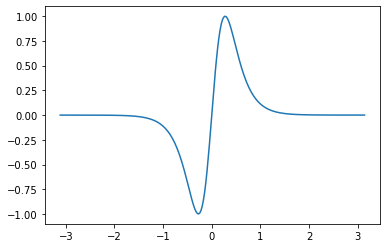

In [51]:
plt.plot(x,u)

In [52]:
k = np.fft.rfftfreq(Nx,d=dx)*2*np.pi
uhat = np.fft.rfft(u)

In [53]:
duhat = 1.j*k*uhat
dudx = np.fft.irfft(duhat)

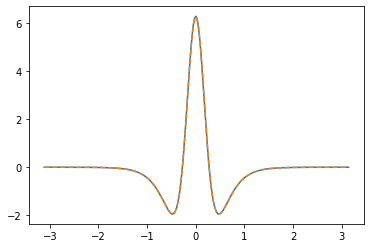

In [54]:
plt.plot(x,dudx)
plt.plot(x,np.gradient(u)/dx,'--')

In [55]:
import pycvodes

In [ ]:
dt = 1.0e-3
S = 0.
Wi = 10.
L = 100
b = L**2
def der_x(c):
    global k
    chat = np.fft.rfft(c)
    return np.fft.irfft(1.j*k*chat)
def rhs_advection(u,c):
    R = np.zeros_like(c)
    for i in range(2):
        R[:,i,i] = -u*der_x(C[:,i,i])
    R[:,0,1] = R[:,1,0] = -u*der_x(C[:,0,1])

    return R

t = 0
C[:,0,0] = 2
nabla_u_all = np.zeros((Nx,2,2))
nabla_u_all[:,0,0] = der_x(u)
nabla_u_all[:,1,1] = -nabla_u_all[:,0,0]
nabla_u_all[:,0,1] = S
y = np.zeros(3)
dydt = np.zeros(3)
Nit = 1000
n = 2
for it in range(Nit):
    R_t = rhs_advection(u,C)

    Cstar = C + dt*R_t
    R_p = np.zeros((Nx,2,2))
    for i in range(Nx):
        nabla_u = nabla_u_all[i,:,:]
        y[0] = C[i,0,0]
        y[1] = C[i,1,1]
        y[2] = C[i,0,1]
        dt0=dt/10.; t0=0.0; atol=1e-8; rtol=1e-8
        yout, info = integrate_predefined(f, j, y, [0,dt], atol, rtol, dt0,
                                  method='bdf')
        R_p[i,0,0] = (yout[-1,0] - y[0])/dt
        R_p[i,1,1] = (yout[-1,1] - y[1])/dt
        R_p[i,0,1] = (yout[-1,2] - y[2])/dt
        R_p[i,1,0] = R_p[i,0,1]
    
    R_t_dt = rhs_advection(u,Cstar)
#     C += dt*(R_t + R_t_dt) + dt*R_p
    C += dt*R_p


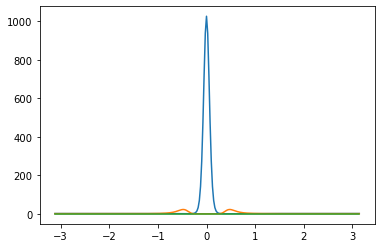

In [61]:
plt.plot(x,C[:,0,0])
plt.plot(x,C[:,1,1])
plt.plot(x,C[:,0,1])

In [24]:
yout

array([[2.02404233, 1.09036495, 0.10310636],
       [2.02438585, 1.09119919, 0.10418678]])